### LSTM Hyper Parameter Tuning for Stock Data Using Keras
Name - Don Lakshitha Udara
ID - S4114011
- MSc in Financial Technology 
- Module - A.I
#### LSTM from Tensorflow tutorials 
https://www.tensorflow.org/tutorials

<img src="https://miro.medium.com/max/1400/1*lFqYLNv0L_05Flk2mJ7ZSw.png" width=600 height=400 />



#### Hyper Parameters vs Model Parameters 
Hyper parameters are used in nueral network training process and they were explicitly configured, on the other hand model parameters are internal to the model itself and normally estimated automatically.

#### Keras Tuner 

Keras tuner is a tuner offered for tensorflow machine learning applications and it can be used to pick the right combination of hyper parameters suited for the ML application.

#### Keras Tuner search models
* RandomSearch
* Hyperband
* BayesianOptimization
* and Sklearn

Lets <font color='green' >Start</font> !


In [1]:
#Importing the libraries 

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import eikon as ek
import keras_tuner as kt

#### Before we go any further lets check the version numbers just for a good measure and to avoid unexpected version related exceptions , if you are getting version related exceptions , it is recomended to setup an enviroment with following versions 

In [2]:
from platform import python_version
print ("Python version")
print (python_version())
print ("Tensorflow Version") 
print(tf.__version__)
print ("Seaborn") 
print(sns.__version__)
print ("Pandas Version") 
print(pd.__version__)
print ("Keras Version") 
print(keras.__version__)
print ("Keras Tuner Version") 
print(kt.__version__)
  

Python version
3.9.7
Tensorflow Version
2.8.0
Seaborn
0.11.2
Pandas Version
1.4.2
Keras Version
2.8.0
Keras Tuner Version
1.1.2


In [3]:
#setting up some parameters 
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
RIC_LIST = ['.FTSE']
ek.set_app_key('#') # refinitive key

In [4]:
# saving the Data in a file in case connectivity errors with refinitiv
if not os.path.isfile('./FTSE_DATA1.csv'):
 
    df = ek.get_timeseries(RIC_LIST,
                           start_date='2017-01-01',
                           end_date='2022-06-02',
                         interval='daily',)
    df.to_csv('./FTSE_DATA1.csv')
else:
    df = pd.read_csv('./FTSE_DATA1.csv',index_col='Date',parse_dates=True)

### Lets See How the data set Looks like


In [5]:
df.head()

,HIGH,CLOSE,LOW,OPEN,VOLUME
Date,,,,,
2017-01-03,7205.45,7177.89,7142.83,7142.83,820156492.0
2017-01-04,7189.74,7189.74,7168.77,7177.89,765000379.0
2017-01-05,7211.96,7195.31,7172.77,7189.74,792495948.0
2017-01-06,7210.05,7210.05,7180.64,7195.31,715797639.0
2017-01-09,7243.76,7237.77,7207.40,7210.05,725810068.0


In [6]:
df.shape

(1369, 5)

<AxesSubplot:xlabel='Date'>

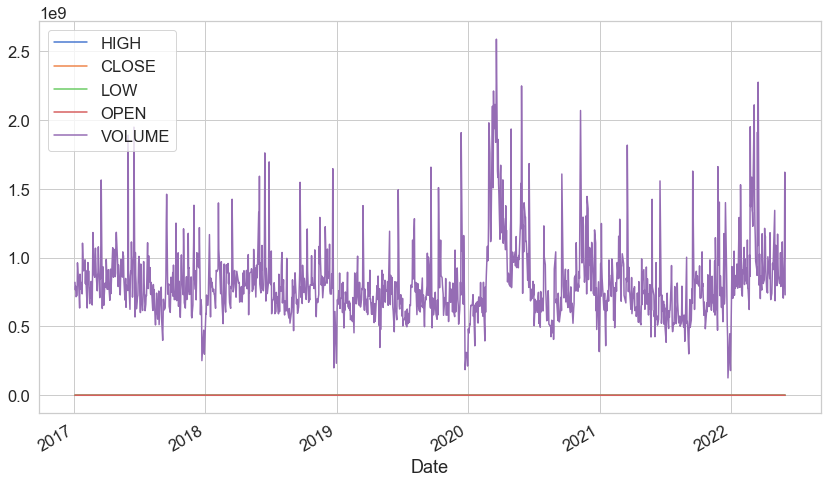

In [7]:
df.plot()

<AxesSubplot:ylabel='Density'>

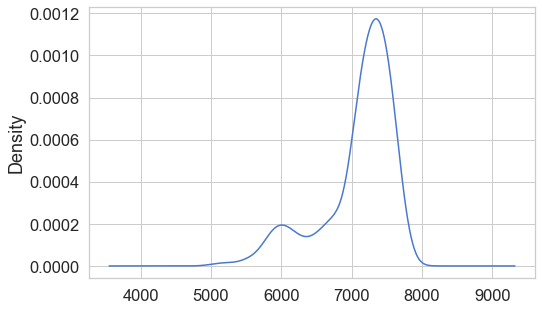

In [8]:
#Distribution of the dataset - picking the Close values only
 
df['CLOSE'].plot(kind='kde',figsize=(8, 5)) 

#### Time Series Decompose 
- Lets see the seasonality of the time series

In [198]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decompose_add = seasonal_decompose(x=df['CLOSE'], 
                                          model='additive', 
                                          period=36)
estimated_trend_add = ts_decompose_add.trend
estimated_seasonal_add = ts_decompose_add.seasonal
estimated_residual_add = ts_decompose_add.resid

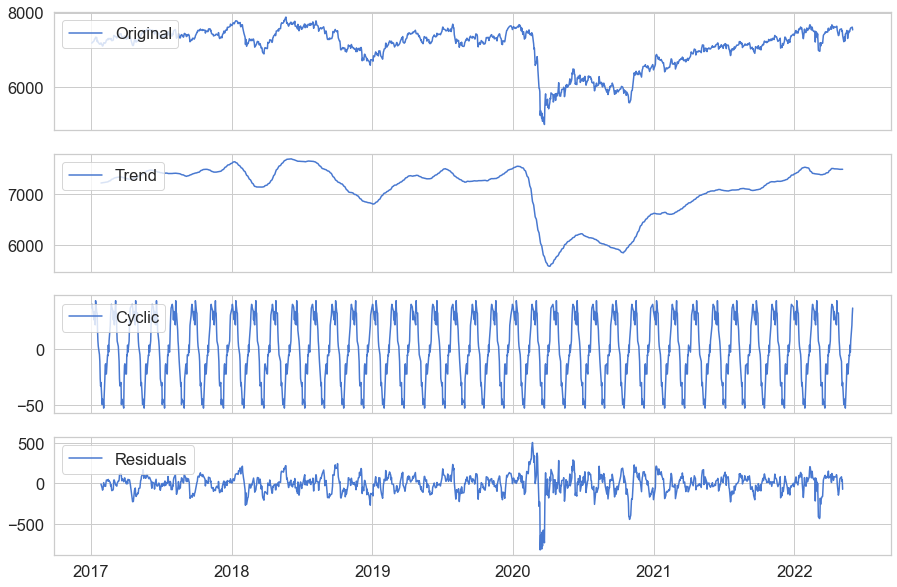

In [199]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df['CLOSE'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend_add, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal_add, label='Cyclic')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual_add, label='Residuals')
axes[3].legend(loc='upper left');

#### Lets Start Hyper Parameter Tuning for ML

In [9]:
scaler = MinMaxScaler()
close_price = df.filter(['Date', 'CLOSE'])
scaler.fit(close_price)
scaled_close = scaler.transform(close_price)


In [10]:
#Taking only the close values
df = df['CLOSE'].values
df = df.reshape(-1, 1)
np.isnan(close_price).any() # checking nan values


CLOSE    False
dtype: bool

In [11]:
trainSet = np.array(df[:int(df.shape[0]*0.8)])
testSet = np.array(df[int(df.shape[0]*0.8):])

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
trainSet = scaler.fit_transform(trainSet)
testSet = scaler.transform(testSet)

In [13]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [14]:
xTrain, yTrain = create_dataset(trainSet)
xTest, yTest = create_dataset(testSet)


In [15]:
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

#### HP tuning using Keras Random Search

In [16]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from tensorflow.keras import layers

In [17]:
def buildModel(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(50,1)))
    for j in range(hp.Int('layers',2,6)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_'+str(j),50,100,step=12),
        activation=hp.Choice('act_'+str(j),['relu','sigmoid'])))
    model.add(layers.Dense(units=hp.Int('units',min_value=32,max_value=512,step=128),activation='relu'))
    model.add(layers.Dense(1,activation='softmax'))
    model.add(keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, 
pass an additional overwrite=True argument while instantiating the tuner.

In [19]:
randomSearchTuner = RandomSearch(
    buildModel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='lstm_tuner_1',
    project_name='random_search2')

In [212]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="lstm_tune/random_search1",
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
earlyStopingCallback = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)];

In [20]:
randomSearchTuner.search_space_summary()

Search space summary
Default search space size: 8
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 12, 'sampling': None}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 12, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [23]:
randomSearchTuner.search(xTrain, yTrain, epochs=25, validation_split=0.2, callbacks=earlyStopingCallback,validation_data=(xTest, yTest))


Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


2022-06-10 18:23:07,377 P[24724] [MainThread 24864] Oracle triggered exit


In [24]:
rsBestValues=randomSearchTuner.get_best_hyperparameters(num_trials=1)[0]
rsBestValues.values

{'layers': 3,
 'units_0': 62,
 'act_0': 'sigmoid',
 'units_1': 74,
 'act_1': 'sigmoid',
 'units': 288,
 'dropout': 0.1,
 'learning_rate': 0.01,
 'units_2': 50,
 'act_2': 'relu'}

In [25]:
def FindBatchSize(model):
    """model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound

In [26]:
batchSize = FindBatchSize(buildModel)
batchSize

8

#### Lets get the epoch value

In [233]:
valAccPerEpoch = history.history['accuracy']
bestEpochRS = valAccPerEpoch.index(max(valAccPerEpoch)) + 1

In [234]:
bestEpochRS

3

In [235]:
earlyStopingCallback = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)];

In [27]:
model = randomSearchTuner.hypermodel.build(rsBestValues)
history = model.fit(xTrain, yTrain, batch_size=batchSize,epochs=50)

Epoch 1/50
131/131 [==============================] - 1s 2ms/step - loss: 5.0233 - accuracy: 9.5694e-04
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 5.0806 - accuracy: 9.5694e-04
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 5.0154 - accuracy: 9.5694e-04
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 5.0607 - accuracy: 9.5694e-04
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 5.1394 - accuracy: 9.5694e-04
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 5.0969 - accuracy: 0.0000e+00
Epoch 7/50
131/131 [==============================] - 0s 2ms/step - loss: 5.0407 - accuracy: 0.0019
Epoch 8/50
131/131 [==============================] - 0s 2ms/step - loss: 5.1453 - accuracy: 0.0019
Epoch 9/50
131/131 [==============================] - 0s 2ms/step - loss: 5.2084 - accuracy: 9.5694e-04
Epoch 10/50
131/131 [==============================] - 0s 2ms/step - los

In [242]:
model = randomSearchTuner.hypermodel.build(rsBestValues)
history = model.fit(xTrain, yTrain, epochs=25, batch_size=batchSize)

valAccPerEpoch = history.history['accuracy']
bestEpochRS = valAccPerEpoch.index(max(valAccPerEpoch)) + 1
print('Best epoch: %d' % (bestEpochRS,))

Epoch 1/25
131/131 [==============================] - 1s 3ms/step - loss: 7.2202 - accuracy: 9.5694e-04
Epoch 2/25
131/131 [==============================] - 0s 3ms/step - loss: 7.1205 - accuracy: 9.5694e-04
Epoch 3/25
131/131 [==============================] - 0s 2ms/step - loss: 7.1448 - accuracy: 0.0019
Epoch 4/25
131/131 [==============================] - 0s 2ms/step - loss: 7.1082 - accuracy: 0.0019
Epoch 5/25
131/131 [==============================] - 0s 2ms/step - loss: 7.0107 - accuracy: 9.5694e-04
Epoch 6/25
131/131 [==============================] - 0s 2ms/step - loss: 7.2092 - accuracy: 0.0000e+00
Epoch 7/25
131/131 [==============================] - 0s 2ms/step - loss: 6.9333 - accuracy: 0.0000e+00
Epoch 8/25
131/131 [==============================] - 0s 2ms/step - loss: 6.9600 - accuracy: 9.5694e-04
Epoch 9/25
131/131 [==============================] - 0s 2ms/step - loss: 6.9845 - accuracy: 0.0000e+00
Epoch 10/25
131/131 [==============================] - 0s 2ms/step - los

In [ ]:
model = randomSearchTuner.hypermodel.build(rsBestValues)
model.fit(xTrain, yTrain, best_epoch, batch_size=batchSize)

In [228]:
best_epoch

NameError: name 'best_epoch' is not defined

In [28]:
predictionsLSTM = model.predict(xTest)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

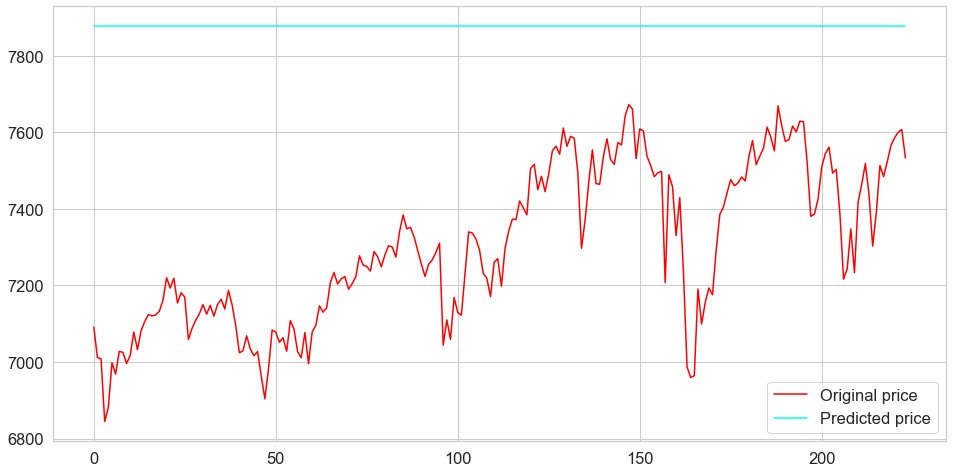

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTM, color='cyan', label='Predicted price')
plt.legend()

In [138]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [139]:
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [145]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.fit(xTrain, yTrain, epochs=50, batch_size=32)
model.save('cse_predict.cse')

Epoch 1/50
33/33 [==============================] - 0s 3ms/step - loss: 5.2819 - accuracy: 9.5694e-04
Epoch 2/50
33/33 [==============================] - 0s 3ms/step - loss: 5.0377 - accuracy: 9.5694e-04
Epoch 3/50
33/33 [==============================] - 0s 3ms/step - loss: 5.0741 - accuracy: 0.0000e+00
Epoch 4/50
33/33 [==============================] - 0s 3ms/step - loss: 5.1280 - accuracy: 0.0019
Epoch 5/50
33/33 [==============================] - 0s 2ms/step - loss: 5.0598 - accuracy: 9.5694e-04
Epoch 6/50
33/33 [==============================] - 0s 3ms/step - loss: 4.9424 - accuracy: 9.5694e-04
Epoch 7/50
33/33 [==============================] - 0s 3ms/step - loss: 5.0302 - accuracy: 0.0019
Epoch 8/50
33/33 [==============================] - 0s 3ms/step - loss: 5.0524 - accuracy: 9.5694e-04
Epoch 9/50
33/33 [==============================] - 0s 3ms/step - loss: 5.2174 - accuracy: 9.5694e-04
Epoch 10/50
33/33 [==============================] - 0s 3ms/step - loss: 5.2522 - accuracy

2022-06-10 18:25:22,808 P[24724] [MainThread 24864] Assets written to: cse_predict.cse\assets


In [31]:
#this may take a while
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
model = load_model('cse_predict.cse')

In [32]:
 
predictionsLSTM = model.predict(xTest)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

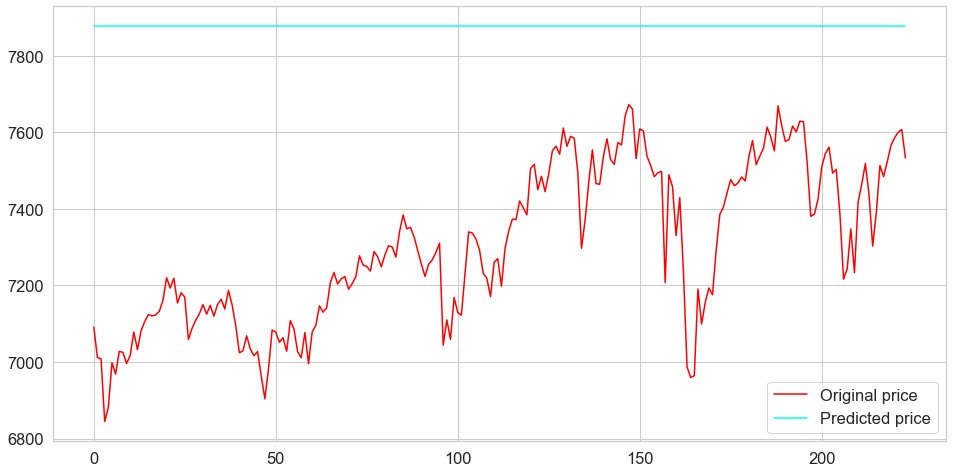

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTM, color='cyan', label='Predicted price')
plt.legend()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [24]:
#creating a new dataframe and adding the LSTM predications and the original set
dtf = pd.DataFrame(y_test_scaled, columns=['Original'])
dtf['LSTM'] =  predictionsLSTM

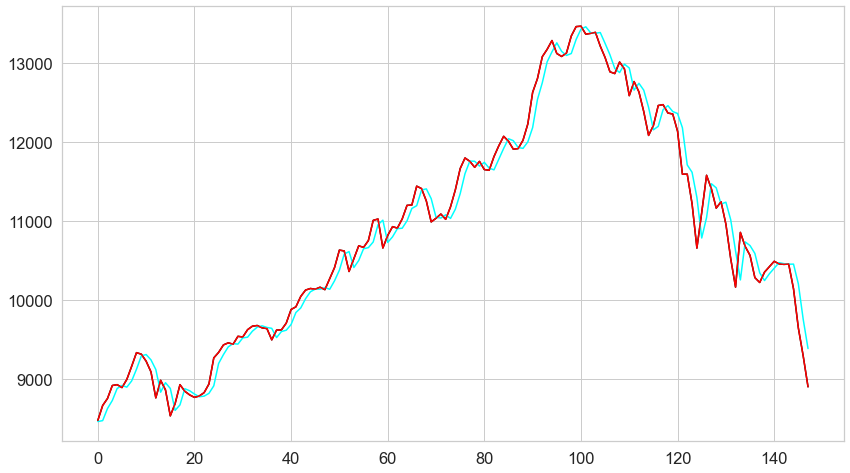

In [25]:
 
from statsmodels.tsa.api import SimpleExpSmoothing
data = y_test_scaled
fit_1 = SimpleExpSmoothing(data, initialization_method='heuristic').fit(smoothing_level=0.8,optimized=False)
fit_2 = SimpleExpSmoothing(data, initialization_method='heuristic').fit(smoothing_level=0.6,optimized=False)
forecast1 = data
plt.plot(data, color='black')
plt.plot(fit_1.fittedvalues, color='cyan')
line1, = plt.plot(forecast1, color='red')




In [26]:
#Adding these two predications to the same evaluation model
dtf['ES80'] =  fit_1.fittedvalues
dtf['ES60'] =  fit_2.fittedvalues #ES60

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  988
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5874.821
Date:                Mon, 18 Apr 2022   AIC                          11761.642
Time:                        18:53:26   BIC                          11791.010
Sample:                             0   HQIC                         11772.811
                                - 988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2526      0.014     18.414      0.000       0.226       0.279
ar.L2         -0.0998      0.016     -6.082      0.000      -0.132      -0.068
ar.L3          0.0780      0.017      4.630      0.0

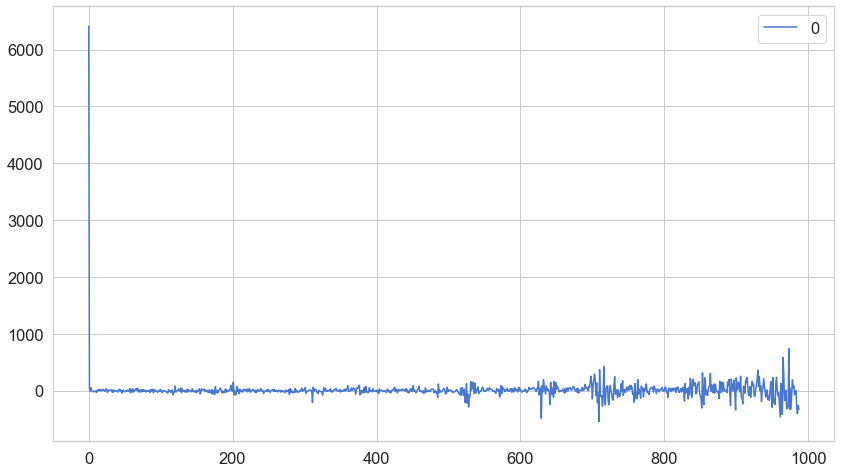

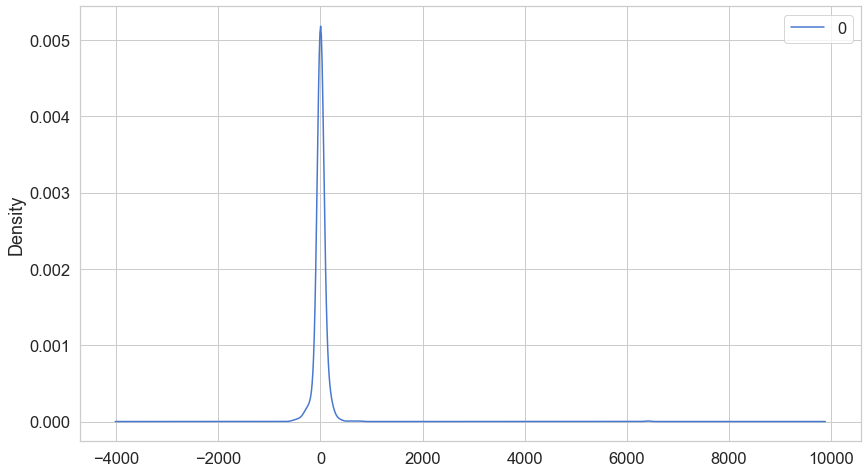

                 0
count   988.000000
mean      8.256687
std     224.135761
min    -542.959588
25%     -22.090901
50%       0.923767
75%      28.384384
max    6411.270000


In [28]:
# fit an ARIMA model and plot residual errors
# got this ARIMA model from the following tutorial
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = df
 # fit model
modelArima = ARIMA(series, order=(5,1,0))
model_fit = modelArima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [44]:
# I got this Arima model from following link and I slightly change it 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# evaluate an ARIMA model using a walk-forward validation
# This too may take a while to complete------ Time to get a Coffee :)
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
 
# Remember we have to re scale the test series before applying it to ARIMA model  
train = scaler.inverse_transform(trainSet)    
test = scaler.inverse_transform(testSet)    
    
#train = trainSet
#test = testSet
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	modelArima = ARIMA(history, order=(5,1,0))
	model_fit = modelArima.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
 # evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))

# plot forecasts against actual outcomes


C:\Users\Udara\AppData\Local\Temp/ipykernel_16556/2383051243.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


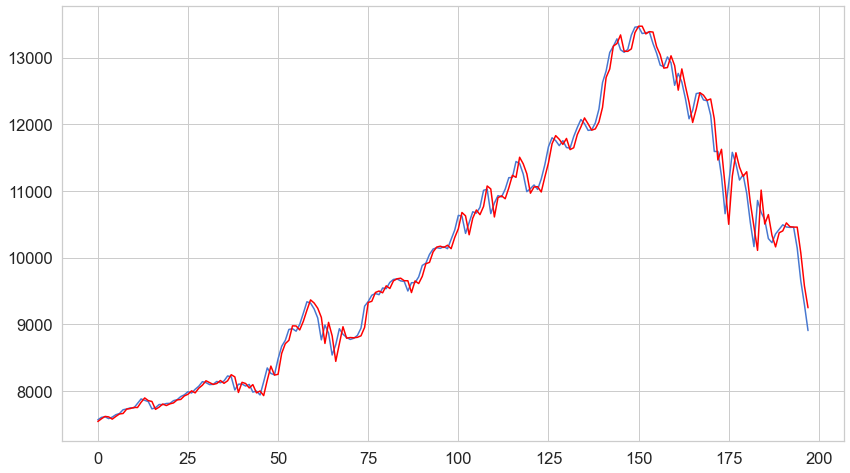

In [45]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show() 

In [46]:
arima =sqrt(mean_squared_error(test,predictions))
print(arima)

169.13231954128798


In [47]:
len(fit_2.fittedvalues)
predicationsArimaTrimmed = np.array(predictions[50:])

In [48]:
len(predicationsArimaTrimmed)
dtf['ARIMA'] =  predicationsArimaTrimmed

In [59]:
dtf.head()


,Original,LSTM,ES80,ES60,ARIMA
0,8479.65,8161.861328,8465.224000,8465.224000,8247.254587
1,8667.95,8250.162109,8476.764800,8473.879600,8561.442401
2,8756.63,8362.769531,8629.712960,8590.321840,8706.999899
3,8920.71,8495.499023,8731.246592,8690.106736,8757.692146
4,8931.33,8641.448242,8882.817318,8828.468694,8974.489188


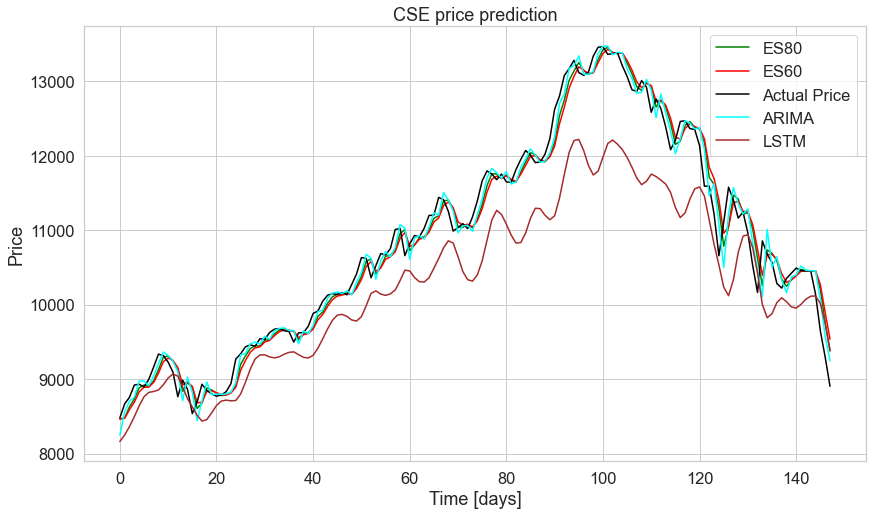

In [50]:
#lets plot all in one now
plt.plot(fit_1.fittedvalues, label = "ES80" ,color='Green') #.8
plt.plot(fit_2.fittedvalues, label = "ES60",color='Red') # .6 
plt.plot(dtf['Original'],label = "Actual Price", color='black') # actual
plt.plot(predicationsArimaTrimmed, label = "ARIMA",color='cyan')  # Arima
plt.plot(dtf['LSTM'],label = "LSTM",color='Brown') # LSTM

plt.title('CSE price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

## Suprisingly almost all the models did well in forecasting 

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
es80=sqrt(mean_squared_error(dtf['Original'],dtf['ES80']))
print(es80)
es60=sqrt(mean_squared_error(dtf['Original'],dtf['ES60']))
print(es60)
lstm=sqrt(mean_squared_error(dtf['Original'],dtf['LSTM']))
print(lstm)
arima =sqrt(mean_squared_error(dtf['Original'],dtf['ARIMA']))
print(arima)

 

208.12169624222378
230.32296612463875
717.4241098734091
191.81600017915153
0.0


<AxesSubplot:title={'center':'Box Plot of daily returns for all the assets'}>

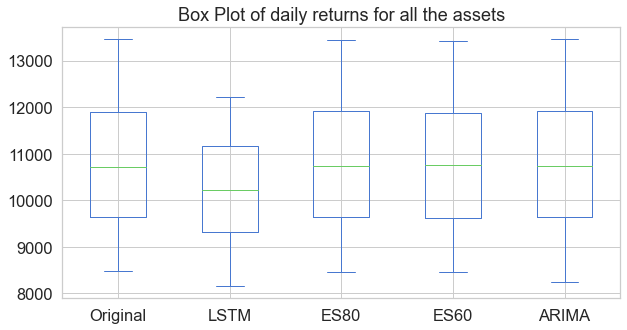

In [52]:
dtf.plot.box(figsize = (10,5), title = "Predications summary values")

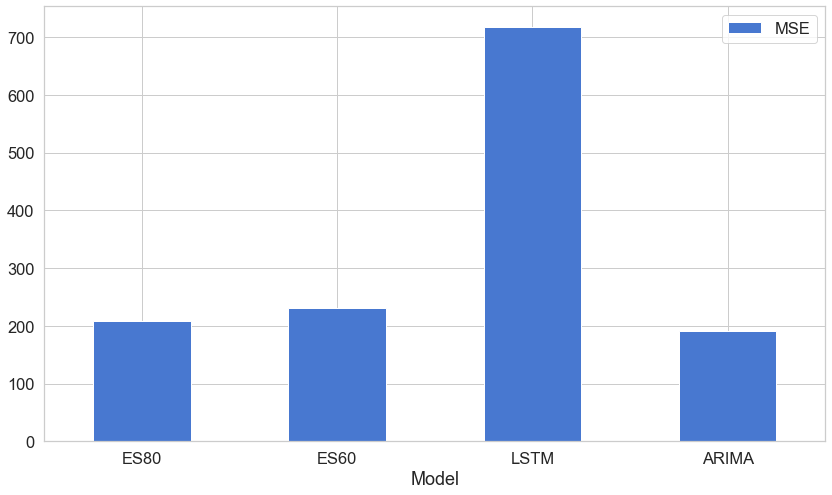

In [55]:
df = pd.DataFrame({'Model':['ES80', 'ES60', 'LSTM','ARIMA'], 'MSE':[208.12169624222378, 230.32296612463875, 717.4241098734091,191.81600017915153
]})
ax = df.plot.bar(x='Model', y='MSE', rot=0)

#### Result 
- All the models did really well but there are two models which stand out from the rest,
- ARIMA & ES80 even from the box plot you can see both models were pretty similar to the Original plot
- In we can round up by saying ARIMA is the best fit model for CSE 
#### Future Work
- check how to fine tune LSTM model to compete with the Arima model
= Use this base forecasting methods to build a stock forecasting appliction for CSE
